<a href="https://colab.research.google.com/github/sameer-karim/w207-final-project/blob/project/DT_car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data manipulation and numerical operations
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and statistical models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_percentage_error

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')
from google.colab import drive
import pandas as pd
import pandas as pd
import numpy as np
from tabulate import tabulate
import re

Mounted at /content/drive


In [2]:
# Path to your file
file_path = '/content/drive/My Drive/UCB_MIDS_2023/w207/car_price_prediction.csv'

# Load the data into a DataFrame
df = pd.read_csv(file_path)

df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
#Data Preprocessing and Splits
#remove km and convert from string to int
df['Mileage'] = df['Mileage'].str.replace(' km', '').astype(int)

# Function to remove 'turbo' and convert to numeric
def clean_engine(value):
    if 'turbo' in value:
        value = value.replace(' turbo', '')
    return pd.to_numeric(value, errors='coerce')

# Apply the function to the 'Engine' column
df['Engine volume'] = df['Engine volume'].apply(clean_engine)

#convert doors from string to numeric
# Function to extract numbers from strings
def extract_numbers(column):
    return column.apply(lambda x: re.findall(r'\d+', x)[0])
#apply doors extraction function to column and re-type as a float
df['Doors'] = extract_numbers(df['Doors']).astype(float)

#NOTE THAT THERE ARE ALWAYS TAXES AND FEES SO WE NEED TO DISCUSS WHAT TO DO WITH THIS COLUMN WHEN 0 OR JUST LEAVE IT AND CALL IT OUT IN PRESENTATION
# Replace non-numeric values (e.g., '-') for the Levy Column - the Levy column is taxes and fees upon purchase
df.replace('-', 0, inplace=True)


# Convert appropriate columns to numeric types (assuming these columns are supposed to be numeric)
#['ID', 'Levy','Price', 'Prod. year', 'Cylinders', 'Airbags','Engine volume', 'Mileage','Doors']
columns_to_convert=['ID', 'Levy','Price', 'Prod. year', 'Cylinders', 'Airbags','Engine volume', 'Mileage','Doors']

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column])

# Drop rows with missing values - there are none but we can leave this here anyway
df.dropna(inplace=True)

# Calculate car age
df['car_age'] = 2024 - df['Prod. year']
#drop prod year - optional
#df = df.drop(columns=['Prod. year'])

# Mileage per year
df['mileage_per_year'] = df['Mileage'] / df['car_age']

#drive train rename
df['Drive wheels'] = df['Drive wheels'].replace('4x4', '4WD')

# List of categorical columns
categorical_columns = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

# Initialize the label encoder
label_encoders = {}

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

#Split labels
column_names_list = list(df.columns)
column_names_list.remove('Price')
X_train=df[column_names_list]
Y_train=df['Price']

# Split the data into training and validation sets 60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [5]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

X_train shape: (10383, 19)
X_val shape: (3461, 19)
X_test shape: (3462, 19)
y_train shape: (10383,)
y_val shape: (3461,)
y_test shape: (3462,)


## Decision Tree Implementation

In [7]:
# Initialize the Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# Initialize the model - this is just a baseline metric to base hyperparameter tuning
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
dt_regressor.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = dt_regressor.predict(X_val)

# Calculate Mean Absolute Percentage Error (MAPE) on the validation set
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE: {val_mape:.2%}')

Validation MAPE: 127480.64%


In [8]:
# Predict on the test set
y_test_pred = dt_regressor.predict(X_test)

# Calculate Mean Absolute Percentage Error (MAPE) on the test set
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE: {test_mape:.2%}')

Test MAPE: 1266.04%


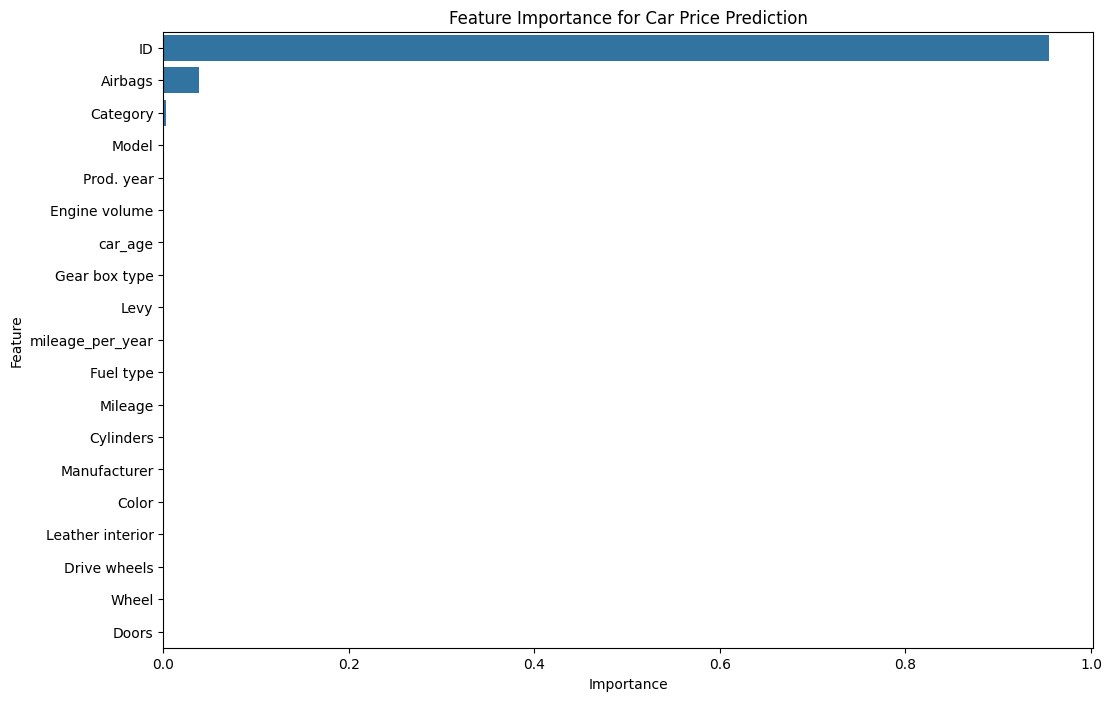

In [9]:
# Feature importance
feature_importances = dt_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Car Price Prediction')
plt.show()


In [4]:
# With the ID having an overwhelming proportion of the importance, lets drop the column
df = df.drop(columns=['ID'])

In [5]:
# Split labels again after dropping 'ID'
column_names_list = list(df.columns)
column_names_list.remove('Price')
X = df[column_names_list]
Y = df['Price']

# Split the data into training and validation sets 60/20/20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [12]:
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = dt_regressor.predict(X_val)

# Calculate Mean Absolute Percentage Error (MAPE) on the validation set
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE: {val_mape:.2%}')


Validation MAPE: 849.06%


In [13]:
# Predict on the test set
y_test_pred = dt_regressor.predict(X_test)

# Calculate Mean Absolute Percentage Error (MAPE) on the test set
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE: {test_mape:.2%}')

Test MAPE: 1277.73%


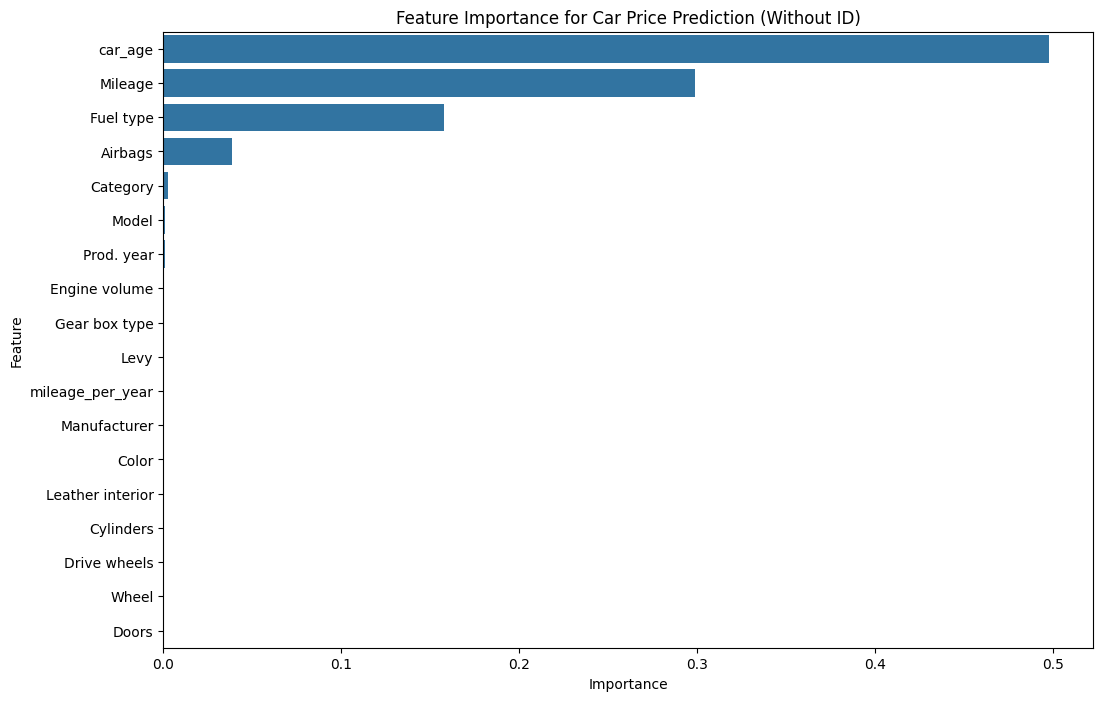

In [14]:
# Feature importance after removing 'ID'
feature_importances = dt_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Car Price Prediction (Without ID)')
plt.show()

#### Much better MAPE metric after the ID column was dropped. The feature importance plot shows that car age, mileage, fuel type, and airbags are the top features influencing the the metric. However the metric is still quite high. Since MAPE is still so high, we will pivot to using a Random Forest Regressor. It is an ensemble method that can hopefully capture the complexity of the dataset after some hyperparameter tuning.

#### More Data Preprocessing

In [6]:
# List of categorical columns
categorical_columns = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

# Initialize the label encoder
label_encoders = {}

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


#### Training and Baseline Modeling

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = rf_regressor.predict(X_val_scaled)

# Calculate MAPE on the validation set
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE: {val_mape:.2%}')

Validation MAPE: 1004.70%


In [17]:
# Predict on the test set
y_test_pred = rf_regressor.predict(X_test_scaled)

# Calculate Mean Absolute Percentage Error (MAPE) on the test set
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE: {test_mape:.2%}')

Test MAPE: 8778.71%


### Feature Importance

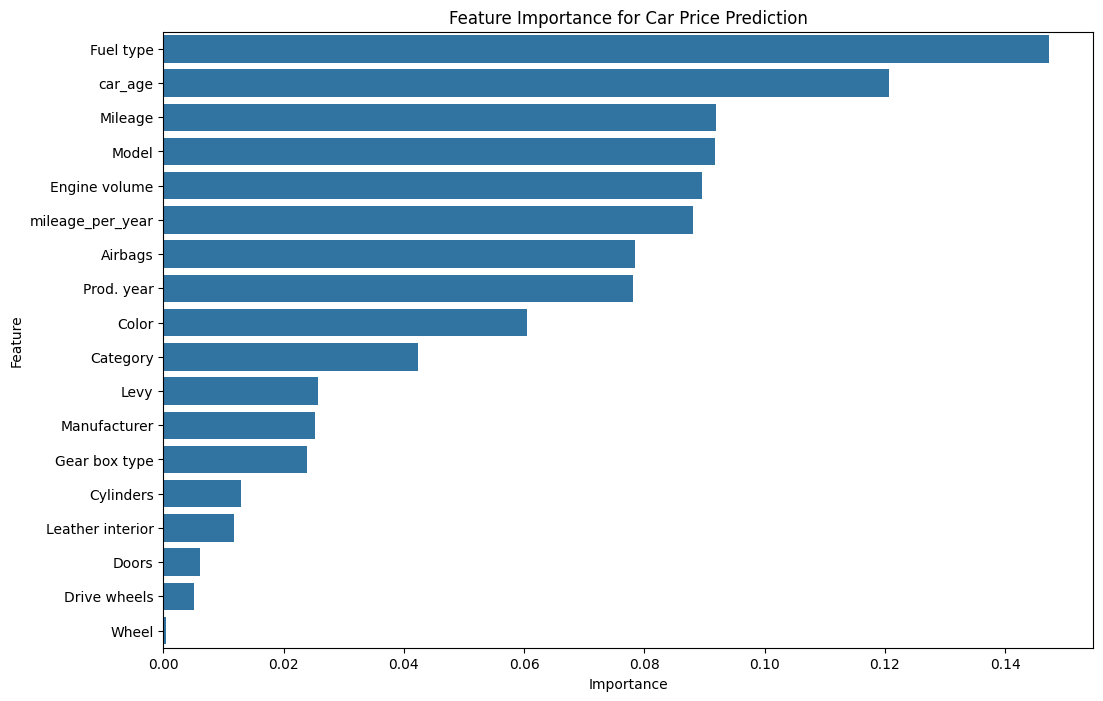

In [18]:
# Feature importance
feature_importances = rf_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Car Price Prediction')
plt.show()

##### Quite a bit more balanced than the initial DT model created earlier. However, with MAPE values being so high we need to tune hyperparameters.

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_distributions,
    n_iter=20,  # Reduced number of parameter settings to sample
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    random_state=42
)


# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Best parameters found
print("Best Parameters:", random_search.best_params_)

# Best score achieved
print("Best Score (Negative MAPE):", random_search.best_score_)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 50, 'bootstrap': False}
Best Score (Negative MAPE): -9.408970842738832


In [20]:
# Get the best model
best_rf_model = random_search.best_estimator_

# Predict and evaluate
y_val_pred = best_rf_model.predict(X_val_scaled)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE with Tuning: {val_mape:.2%}')

y_test_pred = best_rf_model.predict(X_test_scaled)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE with Tuning: {test_mape:.2%}')

Validation MAPE with Tuning: 879.90%
Test MAPE with Tuning: 1064.98%


##### MAPE values still quite high, although the test MAPE has been fine-tuned quite a bit. We may have to revisit feature engineering to establish a better baseline.

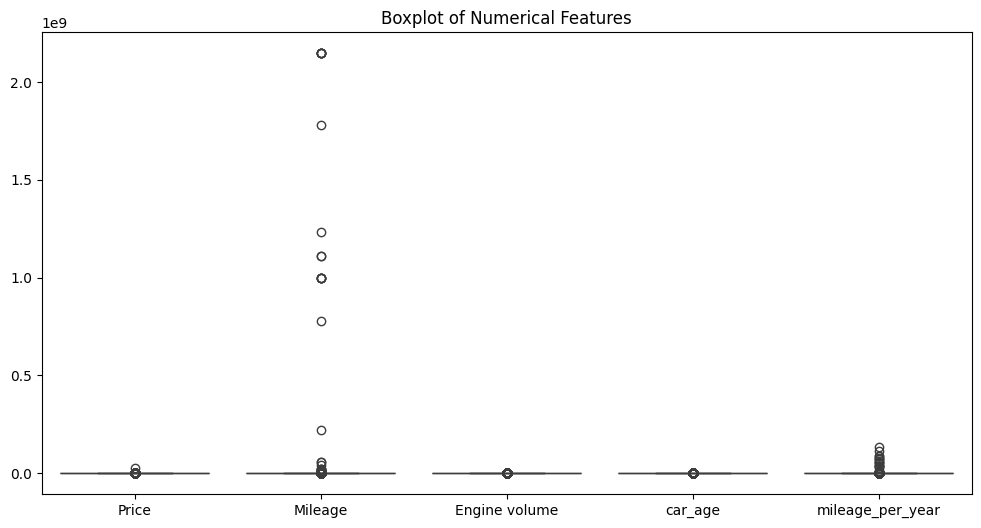

In [21]:
# Boxplot for numerical features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Price', 'Mileage', 'Engine volume', 'car_age', 'mileage_per_year']])
plt.title('Boxplot of Numerical Features')
plt.show()


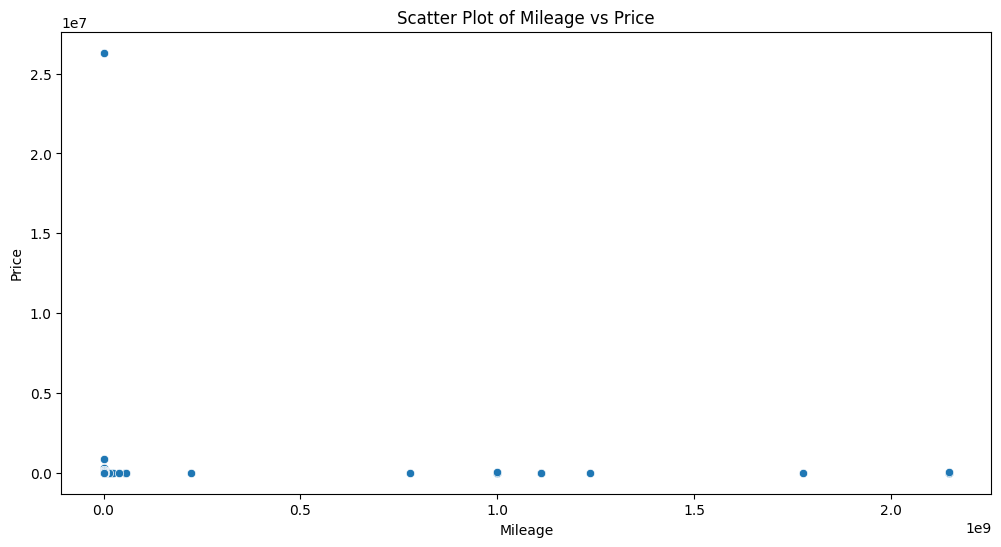

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Mileage', y='Price', data=df)
plt.title('Scatter Plot of Mileage vs Price')
plt.show()

In [7]:
from scipy.stats import zscore

df['Price_zscore'] = zscore(df['Price'])
df['Mileage_zscore'] = zscore(df['Mileage'])

# Identify outliers
price_outliers = df[np.abs(df['Price_zscore']) > 3]
mileage_outliers = df[np.abs(df['Mileage_zscore']) > 3]
print(f'Number of outliers in Price: {price_outliers.shape[0]}')
print(f'Number of outliers in Mileage: {mileage_outliers.shape[0]}')


Number of outliers in Price: 2
Number of outliers in Mileage: 17


In [8]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df[(df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR))]
print(f'Number of outliers in Price using IQR: {outliers.shape[0]}')


Number of outliers in Price using IQR: 914


In [9]:
# Check unique values for a categorical column
print(df['Manufacturer'].unique())

[31  8 20 16 22 57 35 41 44  5  3 40 54 11 27 38 53 45 34 18 15 60 23  1
 55 26  0 32 59 17 10 13 37  9 25 30 24 52 12  6 56  7 42 21 50 61  4 63
 58 36 62 47 51 29 33 14 28 39 46 43 49 48  2 19]


In [10]:
print(df.dtypes)

Price                 int64
Levy                  int64
Manufacturer          int64
Model                 int64
Prod. year            int64
Category              int64
Leather interior      int64
Fuel type             int64
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type         int64
Drive wheels          int64
Doors               float64
Wheel                 int64
Color                 int64
Airbags               int64
car_age               int64
mileage_per_year    float64
Price_zscore        float64
Mileage_zscore      float64
dtype: object


In [11]:
le = LabelEncoder()
df['Manufacturer_encoded'] = le.fit_transform(df['Manufacturer'])
print(df[['Manufacturer', 'Manufacturer_encoded']].drop_duplicates())

       Manufacturer  Manufacturer_encoded
0                31                    31
1                 8                     8
2                20                    20
3                16                    16
5                22                    22
...             ...                   ...
12182            43                    43
12336            49                    49
12534            48                    48
13325             2                     2
18781            19                    19

[64 rows x 2 columns]


In [12]:
df.shape

(17306, 22)

In [13]:
# Applying a filter to the dataset to help remove outliers in the target variable
df_cleaned = df[(df['Price'] >= (Q1 - 1.5 * IQR)) & (df['Price'] <= (Q3 + 1.5 * IQR))]

In [14]:
df_cleaned.columns

Index(['Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags', 'car_age', 'mileage_per_year', 'Price_zscore',
       'Mileage_zscore', 'Manufacturer_encoded'],
      dtype='object')

In [15]:
# Drop original target-related columns if necessary
df_cleaned = df_cleaned.drop(columns=['Price_zscore', 'Manufacturer'])

# Recalculate features and labels
column_names_list = list(df_cleaned.columns)
column_names_list.remove('Price')
X = df_cleaned[column_names_list]
y = df_cleaned['Price']

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [16]:
df_cleaned.shape

(16392, 20)

In [17]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

X_train shape: (9834, 19)
X_val shape: (3279, 19)
X_test shape: (3279, 19)
y_train shape: (9834,)
y_val shape: (3279,)
y_test shape: (3279,)


#### Our sets have a total of ~16,000 rows, with the training set with over 9000 rows. This should be a good amount to run a RandomizedSearchCV to find optimal hyperparameters. GridSearchCV was considered, but we are limited in our computation capabilities. First, let's take an overall look in our cleaned dataset again.

In [18]:
df_cleaned.columns

Index(['Price', 'Levy', 'Model', 'Prod. year', 'Category', 'Leather interior',
       'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type',
       'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'car_age',
       'mileage_per_year', 'Mileage_zscore', 'Manufacturer_encoded'],
      dtype='object')

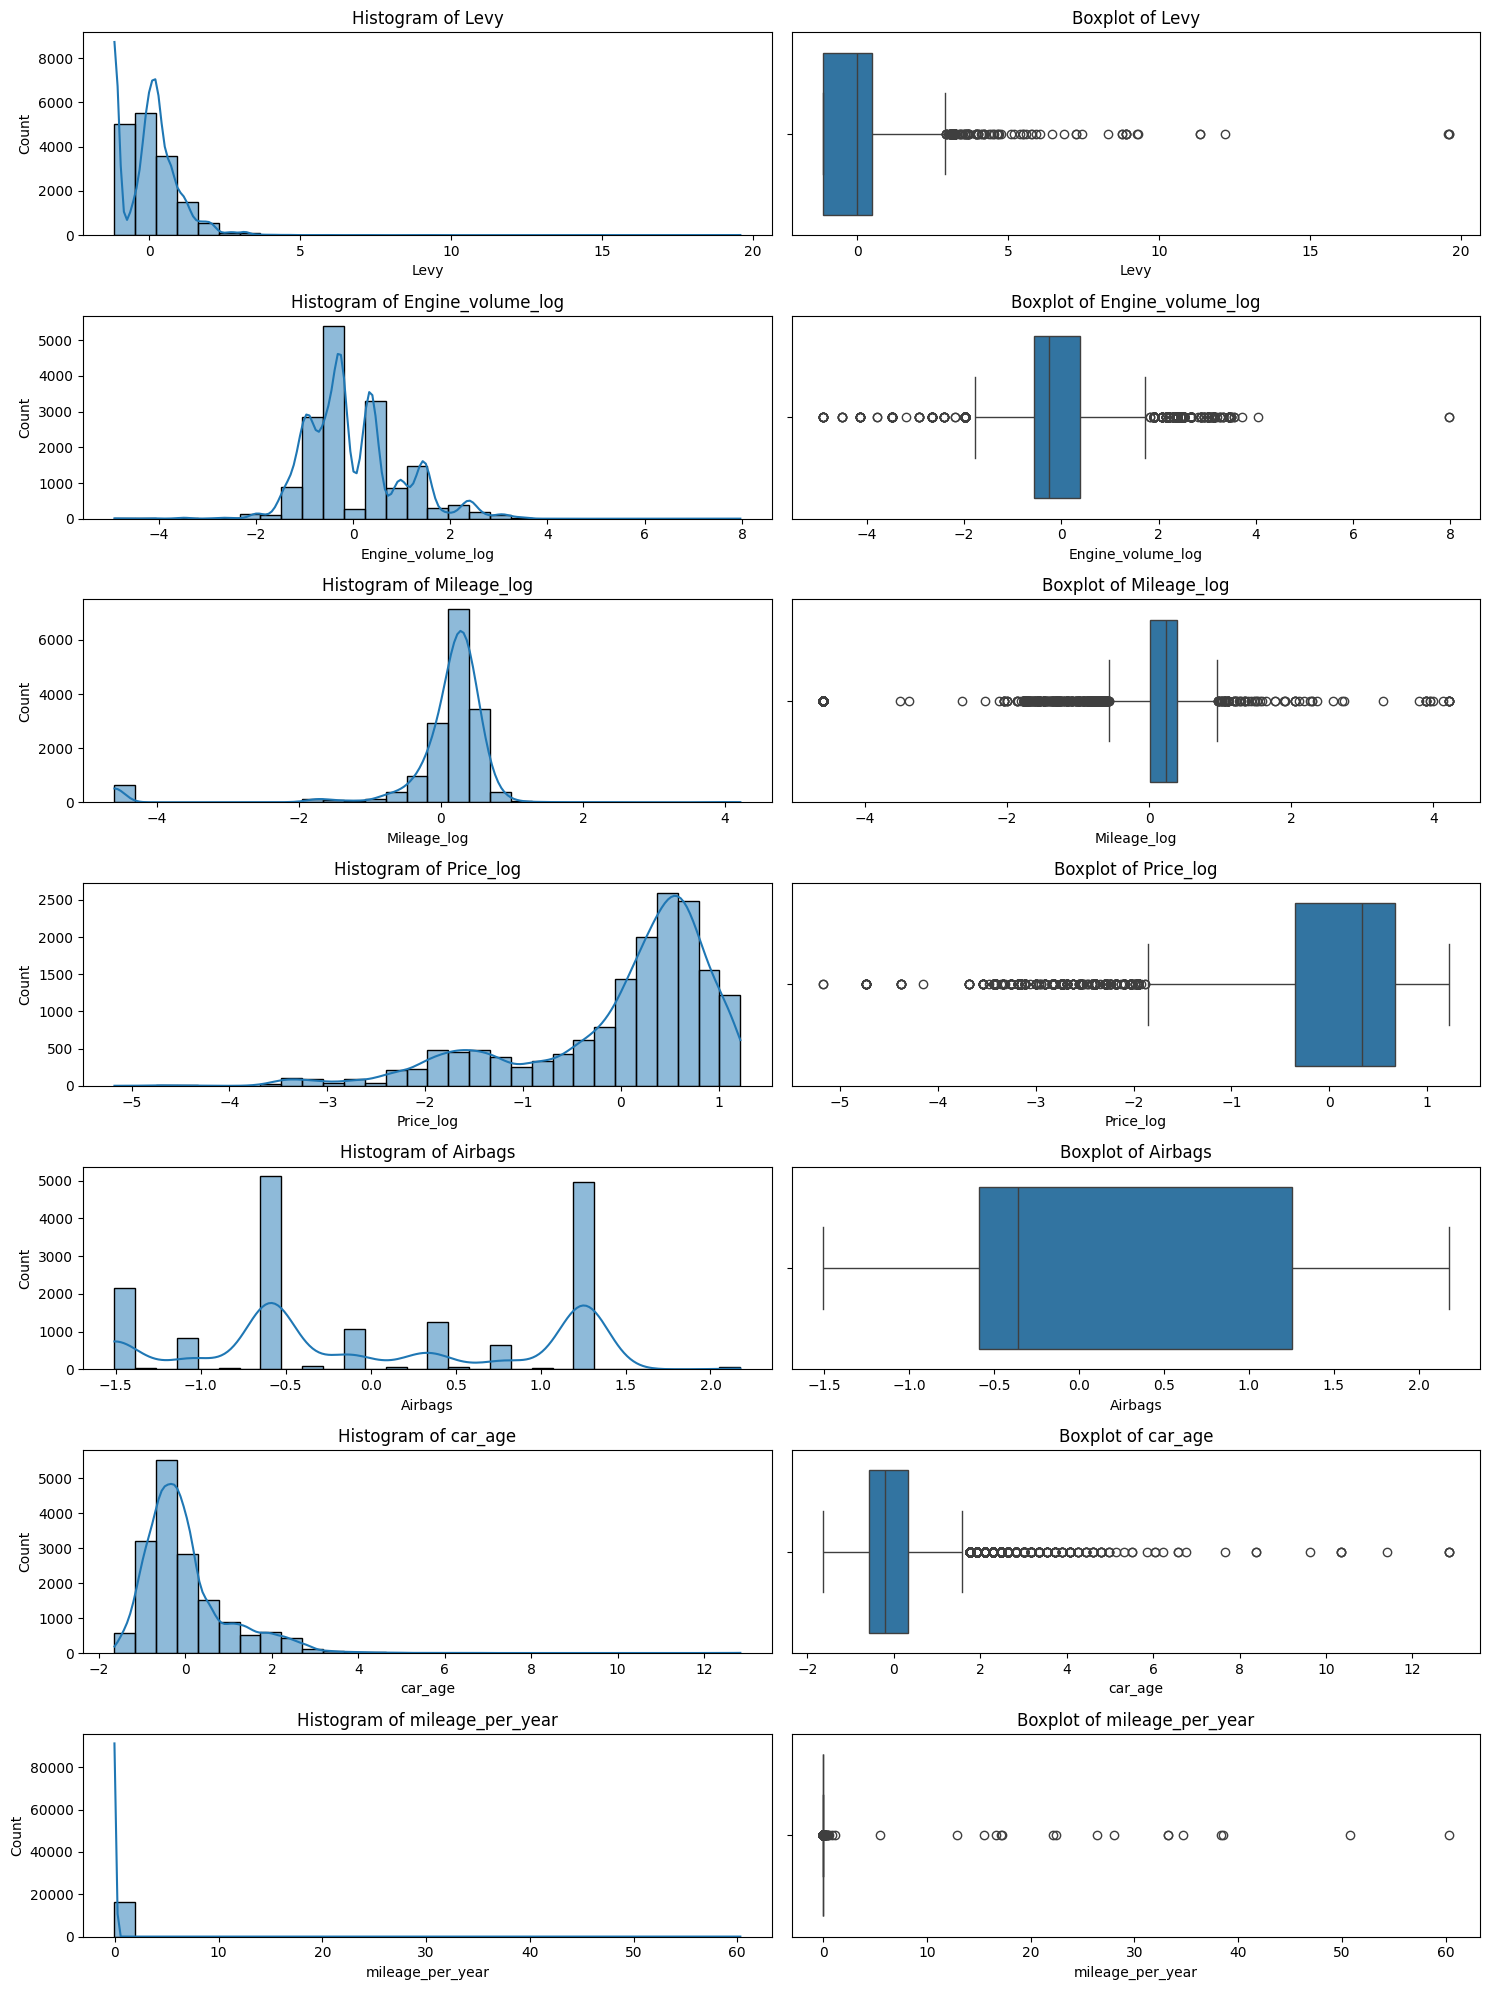

In [19]:
# Apply log transformation to skewed continuous variables
df_cleaned['Price_log'] = np.log1p(df_cleaned['Price'])
df_cleaned['Mileage_log'] = np.log1p(df_cleaned['Mileage'])
df_cleaned['Engine_volume_log'] = np.log1p(df_cleaned['Engine volume'])

# Standardize the numerical features
numerical_features = ['Levy', 'Engine_volume_log', 'Mileage_log', 'Price_log', 'Airbags', 'car_age', 'mileage_per_year']
scaler = StandardScaler()
df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])

# Plot histograms and boxplots for the transformed features
plt.figure(figsize=(15, 20))

# Histograms
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 2, 2*i+1)
    sns.histplot(df_cleaned[feature], bins=30, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

    plt.subplot(len(numerical_features), 2, 2*i+2)
    sns.boxplot(x=df_cleaned[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()


In [20]:
df_cleaned.describe()

,Price,Levy,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,...,Wheel,Color,Airbags,car_age,mileage_per_year,Mileage_zscore,Manufacturer_encoded,Price_log,Mileage_log,Engine_volume_log
count,16392.000000,1.639200e+04,16392.000000,16392.000000,16392.000000,16392.000000,16392.000000,16392.000000,1.639200e+04,16392.000000,...,16392.000000,16392.000000,1.639200e+04,1.639200e+04,1.639200e+04,16392.000000,16392.000000,1.639200e+04,1.639200e+04,1.639200e+04
mean,13273.785200,-2.178183e-17,685.387811,2010.813690,6.310578,0.729746,3.461079,2.287128,1.638846e+06,4.545754,...,0.084309,7.853892,4.480988e-17,2.980101e-18,8.222369e-18,0.001700,32.884273,-5.690367e-16,1.283746e-16,-7.616867e-17
std,11055.560416,1.000031e+00,329.337924,5.593641,2.798326,0.444104,1.777220,0.868413,4.967447e+07,1.142778,...,0.277860,5.322078,1.000031e+00,1.000031e+00,1.000031e+00,1.027506,17.537830,1.000031e+00,1.000031e+00,1.000031e+00
min,1.000000,-1.146280e+00,0.000000,1939.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,...,0.000000,0.000000,-1.507567e+00,-1.642328e+00,-3.465322e-02,-0.032199,0.000000,-5.174891e+00,-4.592458e+00,-4.907454e+00
25%,3920.000000,-1.146280e+00,431.000000,2009.000000,4.000000,0.000000,2.000000,1.800000,7.468800e+04,4.000000,...,0.000000,1.000000,-5.867044e-01,-5.696482e-01,-3.165651e-02,-0.030654,22.000000,-3.467976e-01,6.589641e-03,-5.533708e-01
50%,11447.000000,-4.508731e-03,668.000000,2012.000000,7.000000,1.000000,5.000000,2.000000,1.299290e+05,4.000000,...,0.000000,7.500000,-3.564888e-01,-2.120884e-01,-3.006321e-02,-0.029512,31.000000,3.355899e-01,2.335126e-01,-2.616119e-01
75%,19287.000000,4.734421e-01,976.000000,2014.000000,9.000000,1.000000,5.000000,2.500000,1.900000e+05,4.000000,...,0.000000,12.000000,1.255021e+00,3.242512e-01,-2.813141e-02,-0.028269,54.000000,6.678254e-01,3.892722e-01,3.902648e-01
max,45928.000000,1.958970e+01,1271.000000,2020.000000,10.000000,1.000000,6.000000,20.000000,2.147484e+09,16.000000,...,1.000000,15.000000,2.175883e+00,1.283884e+01,6.029706e+01,44.388044,63.000000,1.220384e+00,4.214382e+00,7.967306e+00


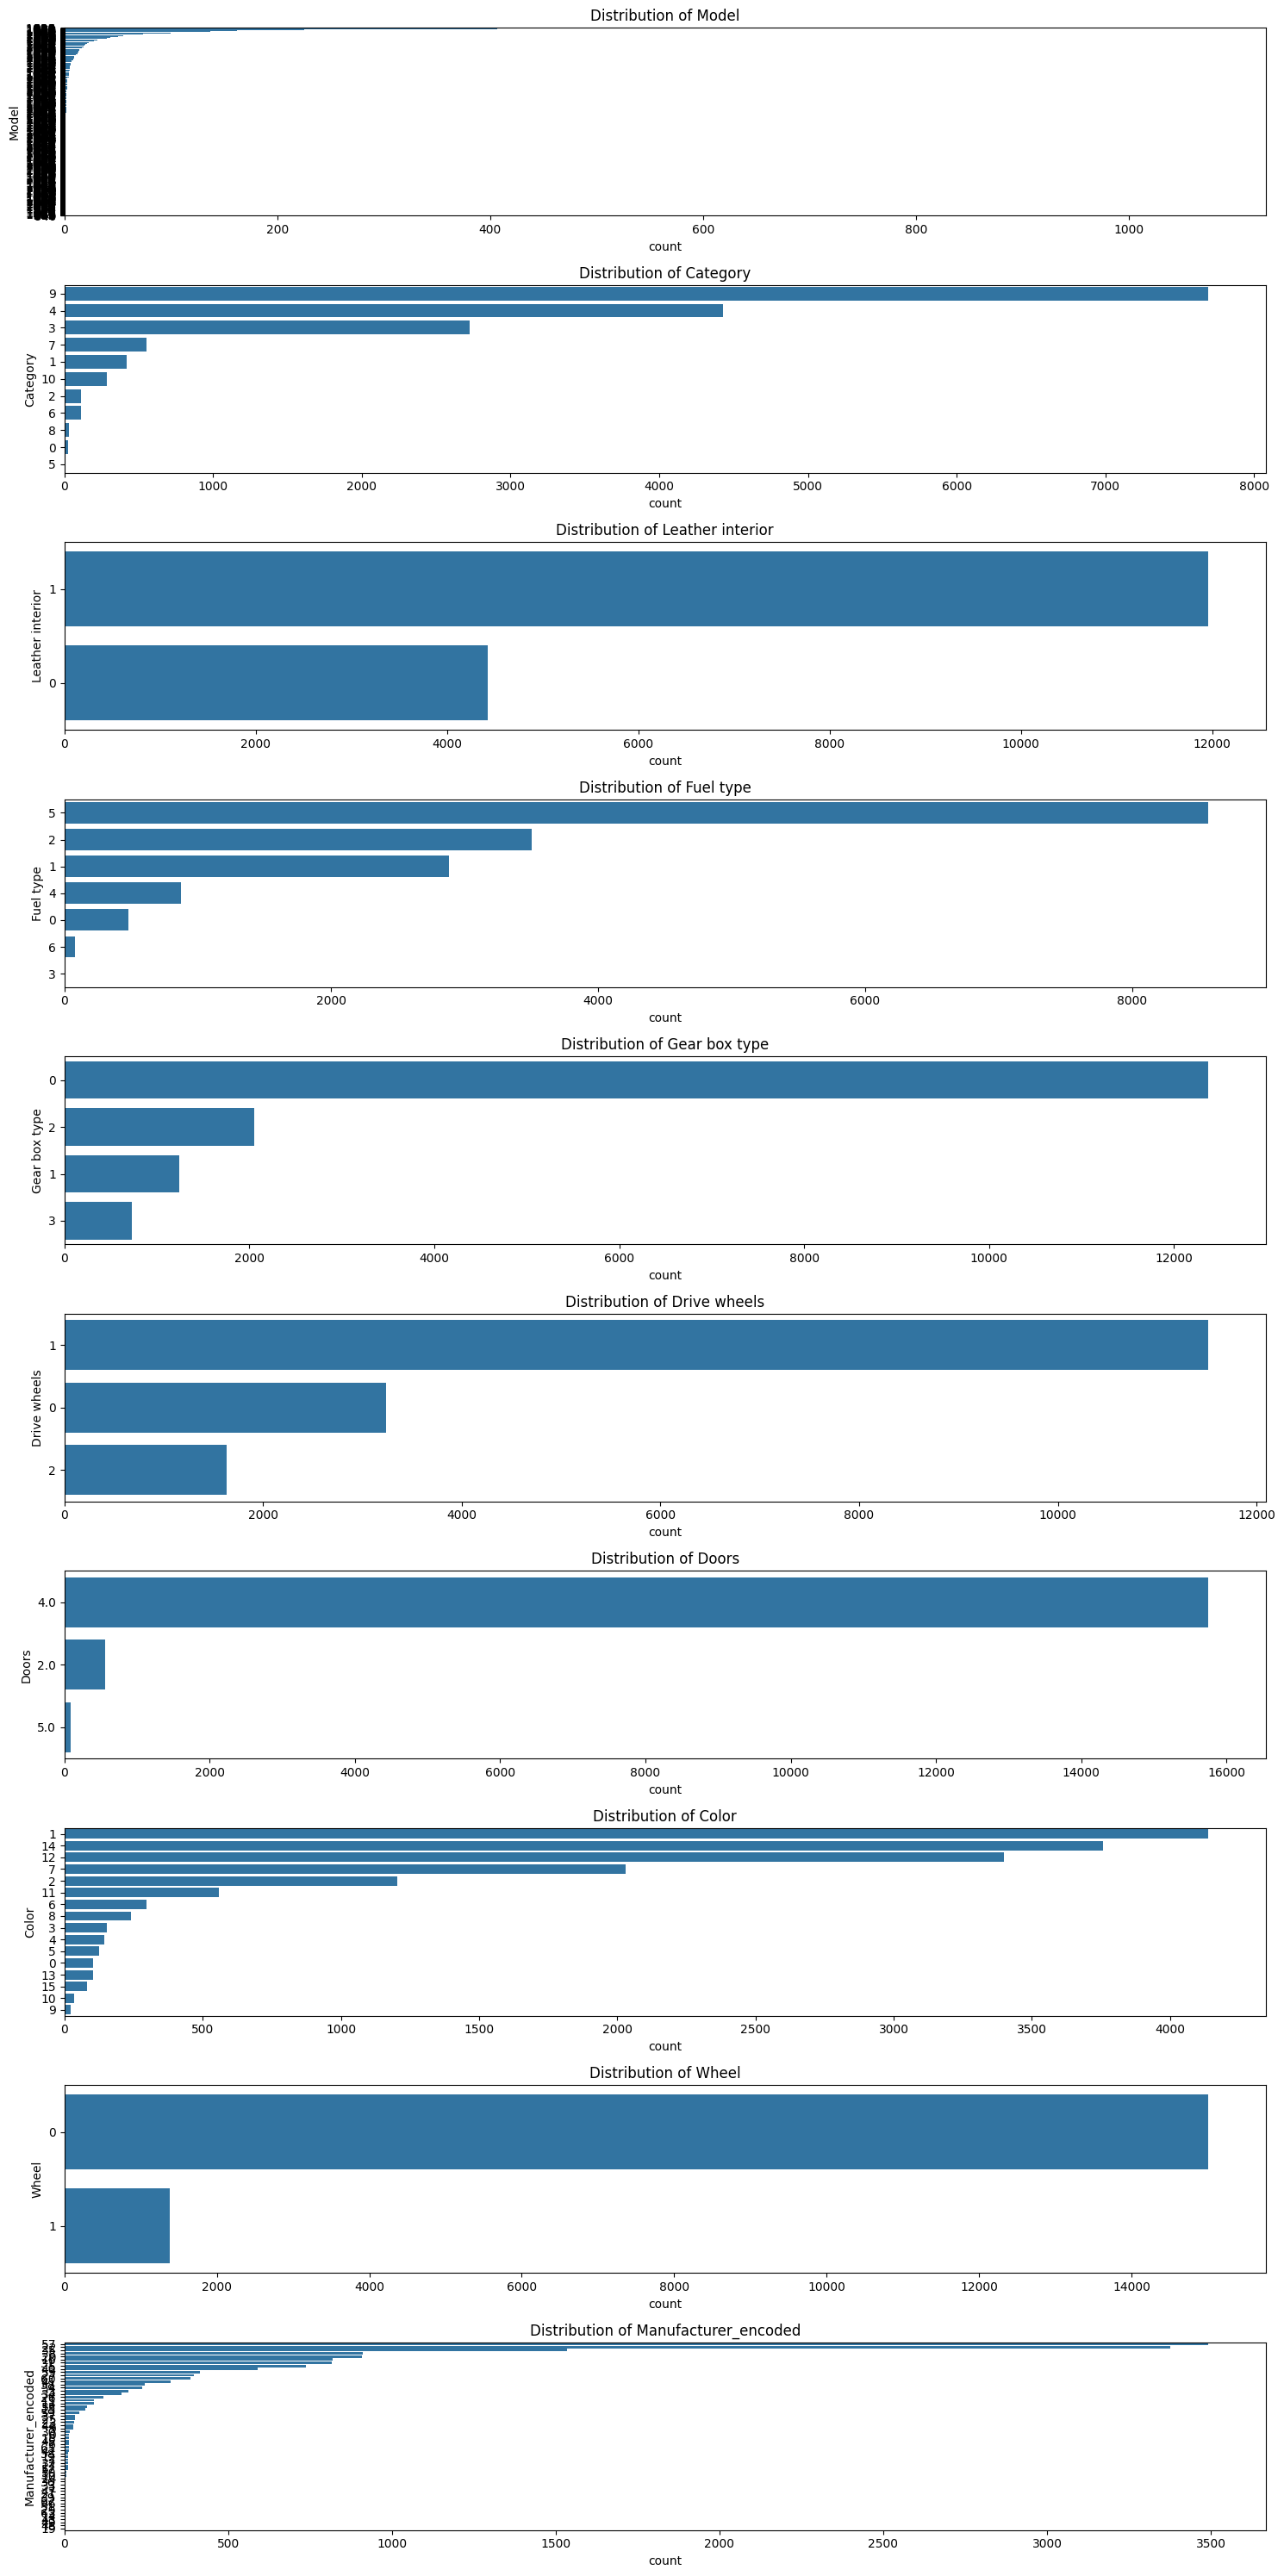

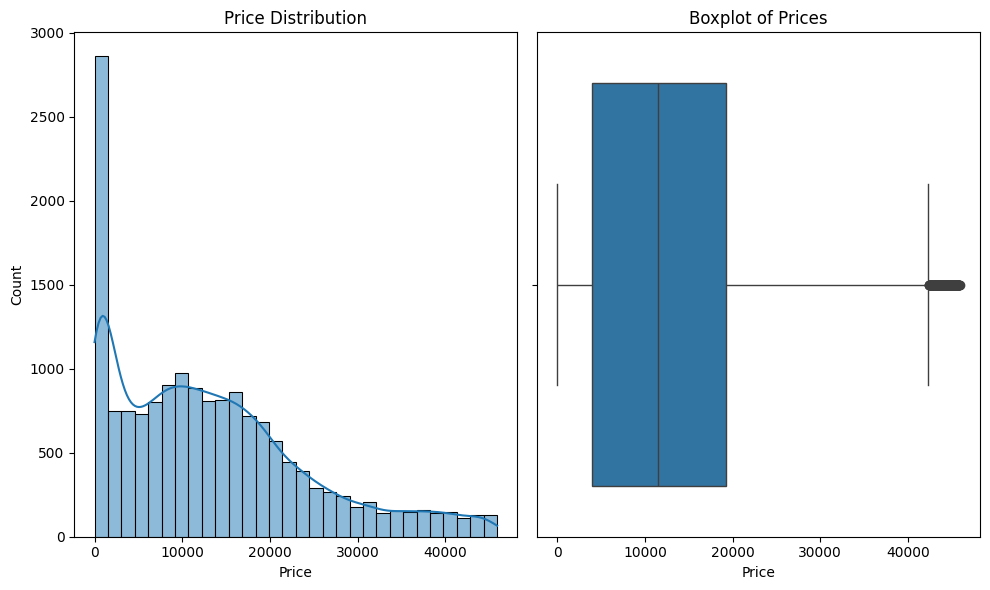

In [21]:
# Update the list of categorical features
categorical_features = ['Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Color', 'Wheel', 'Manufacturer_encoded']

plt.figure(figsize=(15, 30))

# Generate a histogram for each categorical feature
for i, feature in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.countplot(y=feature, data=df_cleaned, order=df_cleaned[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

# Show the count distributions
plt.show()

# Distribution of Price
plt.figure(figsize=(10, 6))

# Histogram for Price
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['Price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

# Boxplot for Price
plt.subplot(1, 2, 2)
sns.boxplot(x='Price', data=df_cleaned)
plt.title('Boxplot of Prices')
plt.xlabel('Price')

plt.tight_layout()
plt.show()


###### Much of our *cleaned* data is heavily skewed - thus we need to perform some more pre-processing in order to attain a more honest dataset.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the features (X) and the target (y)
X = df_cleaned.drop(columns=['Price','Price_log'], axis=1)
y = df_cleaned['Price']

# Split the data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [30]:
# Removed the 'auto' attribute from the max_features parameter
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_distributions,
                               n_iter=100,  # Number of parameter settings sampled
                               cv=3,  # Number of folds in cross-validation
                               verbose=2,  # Controls verbosity of output
                               random_state=42,
                               n_jobs=-1)  # Use all available cores

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get the best parameters and best score from the RandomizedSearchCV
best_params = rf_random.best_params_
best_score = rf_random.best_score_

# Print the best parameters and the best score
print(f"Best Parameters: {best_params}")
print(f"Best Score (Negative MAPE): {best_score}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best Score (Negative MAPE): 0.7535380401221489


In [31]:
# Evaluate the model on the validation set
y_val_pred = rf_random.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

# Print the validation MAPE
print(f"Validation MAPE: {val_mape * 100:.2f}%")

# Evaluate the model on the test set
y_test_pred = rf_random.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the test MAPE
print(f"Test MAPE: {test_mape * 100:.2f}%")

Validation MAPE: 990.61%
Test MAPE: 525.32%


#### MAPE scores are still relatively high, must conduct some further feature engineering to handle the skewness of the various categorical features.  

In [40]:
# For X_train
print(categorical_features)

['Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Color', 'Wheel', 'Manufacturer_encoded']


In [41]:
# Frequency encoding
def frequency_encoding(df, feature_names):
    transformed_df = df.copy()
    for feature in feature_names:
        freq_encoding = transformed_df[feature].value_counts().to_dict()
        transformed_df[feature + '_freq'] = transformed_df[feature].map(freq_encoding)
    return transformed_df


In [42]:
# Apply frequency encoding to the training set
X_train_encoded = frequency_encoding(X_train, categorical_features)

# Apply the same transformations to the validation and test sets
X_val_encoded = frequency_encoding(X_val, categorical_features)
X_test_encoded = frequency_encoding(X_test, categorical_features)


In [44]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Create the RandomizedSearchCV object
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

# Fit the model
rf_random.fit(X_train_encoded, y_train)

# Print the best parameters and best score
print("Best Parameters:", rf_random.best_params_)
print("Best Score (Negative MAPE):", rf_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
63 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
63 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best Score (Negative MAPE): -10.32847237298523


In [45]:
# Validate the model
y_val_pred = rf_random.predict(X_val_encoded)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print("Validation MAPE:", val_mape)

# Test the model
y_test_pred = rf_random.predict(X_test_encoded)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print("Test MAPE:", test_mape)

Validation MAPE: 16.74690095623491
Test MAPE: 12.386057264804302


##### The negative sign for the training MAPE is used to convert the MAPE so that the optimization problem becomes one of maximization. This score suggests that the model predicts values within 10.33% of the actual values in the training set.

##### The test (12.38%) and validation (16.75%) MAPEs are higher than the training score, suggesting some overfitting, although not excessive. The model generalizes reasonably but could still benefit from further optimization in feature engineering, further hyperparameter tuning, or by trying different modeling approaches.